# デノイジングオートエンコーダを用いたAdversarial Examplesの防御

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import foolbox

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import sys
sys.path.append('../libs')

# 自作ライブラリ
import model_zoo as zoo
import measure

Using TensorFlow backend.


## データセット

In [2]:
def addnoise(x, loc=0.0, scale=0.2, minmax=(0.0, 1.0)):
    noise = np.abs(np.random.normal(0.0, 0.2, x.shape))
    x_noise = np.clip(x + noise, minmax[0], minmax[1])
    
    return x_noise

### MNISTのロードとガウシアンノイズの付与

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.
x_test = np.expand_dims(x_test, axis=-1) / 255.

x_train_noised, x_test_noised = addnoise(x_train), addnoise(x_test)

## カスタム評価基準の定義(PSNRとSSIM)
PSNRとSSIMは再構成誤差数値が高い方が良い。  
PSNRの最高値は不定義だが、SSIMの最高値は1.0

In [4]:
model_dir = Path("..", "model_dir")
model_dir.mkdir(exist_ok=True)
dae_path = model_dir/"ConvDAE.h5"

if dae_path.exists():
    dae = keras.models.load_model(str(dae_path), 
                                  custom_objects={"psnr": measure.TFMetrics.psnr, 
                                                  "ssim": measure.TFMetrics.ssim, 
                                                  "distortion": measure.TFMetrics.distortion, 
                                                  "eucdiff": measure.TFMetrics.eucdiff, 
                                                 "infdiff": measure.TFMetrics.infdiff})
    dae.evaluate(x_test_noised, x_test)
else:
    log_dir = Path("..", "logs", "dae")
    tb = TensorBoard(log_dir=str(log_dir))

    dae = zoo.ConvDAE()
    dae.compile(optimizer='Adam', loss='binary_crossentropy', 
                metrics=['mse', measure.TFMetrics.psnr, measure.TFMetrics.ssim, 
                         measure.TFMetrics.distortion, measure.TFMetrics.eucdiff, measure.TFMetrics.infdiff])
    dae.fit(x=x_train_noised, y=x_train, epochs=10, validation_data=(x_test_noised, x_test), callbacks=[tb])
    dae.save(str(dae_path))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
10000/10000 [==============================] - 4s 392us/sample - loss: 2.0670 - mean_squared_error: 0.0015 - psnr: 28.4268 - ssim: 0.9819 - distortion: 0.0392 - eucdiff: 6.2069 - infdiff: 0.5495


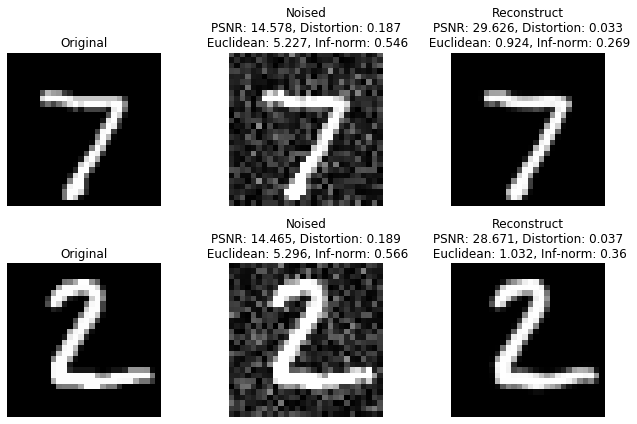

In [5]:
n_vis = 2

recon_test = dae.predict(x_test_noised)

fig = plt.figure(figsize=(9, 6))
for i in range(n_vis):
    # Original Image
    plt.subplot(n_vis, 3, 3*i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(n_vis, 3, 3*i+2)
    plt.imshow(x_test_noised[i].reshape(28, 28), cmap='gray')
    p = measure.NpMetrics.psnr(x_test[i], x_test_noised[i], 1.0)
    d = measure.NpMetrics.distortion(x_test[i], x_test_noised[i])
    e = measure.NpMetrics.eucdiff(x_test[i], x_test_noised[i])
    inf = measure.NpMetrics.infdiff(x_test[i], x_test_noised[i])
    plt.title(f"Noised\nPSNR: {p.round(3)}, Distortion: {d.round(3)}\n Euclidean: {e.round(3)}, Inf-norm: {inf.round(3)}")
    plt.axis('off')
    
    # Reconst image
    plt.subplot(n_vis, 3, 3*i+3)
    plt.imshow(recon_test[i].reshape(28, 28), cmap='gray')
    p = measure.NpMetrics.psnr(x_test[i], recon_test[i], 1.0)
    d = measure.NpMetrics.distortion(x_test[i], recon_test[i])
    e = measure.NpMetrics.eucdiff(x_test[i], recon_test[i])
    inf = measure.NpMetrics.infdiff(x_test[i], recon_test[i])
    plt.title(f"Reconstruct\nPSNR: {p.round(3)}, Distortion: {d.round(3)}\n Euclidean: {e.round(3)}, Inf-norm: {inf.round(3)}")
    plt.axis('off')
plt.tight_layout()

## ターゲットCNNに対するAdversarial Attack
ここでは、実際にFGSMで攻撃するtarget_cnnと、攻撃をしないprune_cnnを定義して、攻撃の転移性を見る。  

In [7]:
target_cnn_path = model_dir/"target_cnn.h5"

if target_cnn_path.exists():
    target_cnn = keras.models.load_model(str(target_cnn_path))
else:
    log_dir = Path('..', 'logs', 'target_cnn')
    target_cnn = zoo.CNN(n_convset=2, n_dense=2)
    tb = TensorBoard(log_dir=str(log_dir))
    target_cnn.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    target_cnn.fit(x=x_train, y=y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[tb])
    target_cnn.save(str(target_cnn_path))

In [8]:
prune_cnn_path = model_dir/"prune_cnn.h5"

if prune_cnn_path.exists():
    prune_cnn = keras.models.load_model(str(prune_cnn_path))
else:
    log_dir = Path('..', 'logs', 'prune_cnn')
    prune_cnn = zoo.CNN(n_convset=3, n_dense=2)
    tb = TensorBoard(log_dir=str(log_dir))
    prune_cnn.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    prune_cnn.fit(x=x_train, y=y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[tb])
    prune_cnn.save(str(prune_cnn_path))

In [9]:
# ターゲットCNNをfoolモデルとしてラッピング
fmodel = foolbox.models.TensorFlowModel.from_keras(target_cnn, bounds=(0, 1))
# 攻撃の評価基準
attack_criterion = foolbox.criteria.Misclassification()
# 攻撃手法を定義
fgsm = foolbox.attacks.FGSM(fmodel, criterion=attack_criterion)

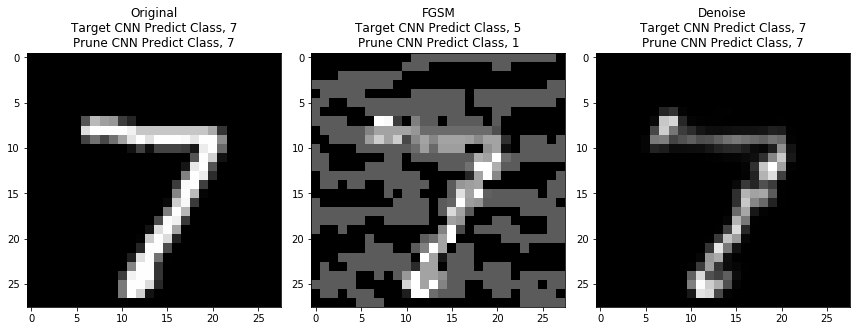

In [10]:
idx = 0
x_adv = fgsm(input_or_adv=x_test[idx], label=y_test[idx], unpack=False)

fig = plt.figure(figsize=(12, 6))

# オリジナル画像
plt.subplot(1, 3, 1)
plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
plt.title(f'Original\n'+
           f'Target CNN Predict Class, {target_cnn.predict_classes(x_test[idx].reshape(1, 28, 28, 1))[0]}\n'+
           f'Prune CNN Predict Class, {prune_cnn.predict_classes(x_test[idx].reshape(1, 28, 28, 1))[0]}'
          )

# FGSM画像
plt.subplot(1, 3, 2)
plt.imshow(x_adv.image.reshape(28, 28), cmap='gray')
plt.title(f'FGSM\n'+
           f'Target CNN Predict Class, {target_cnn.predict_classes(x_adv.image.reshape(1, 28, 28, 1))[0]}\n'+
           f'Prune CNN Predict Class, {prune_cnn.predict_classes(x_adv.image.reshape(1, 28, 28, 1))[0]}'
          )

# デノイジング画像
denoise_adv = dae.predict(x_adv.image.reshape(1, 28, 28, 1))
plt.subplot(1, 3, 3)
plt.imshow(denoise_adv.reshape(28, 28), cmap='gray')
plt.title(f'Denoise\n'+
           f'Target CNN Predict Class, {target_cnn.predict_classes(denoise_adv)[0]}\n'+
           f'Prune CNN Predict Class, {prune_cnn.predict_classes(denoise_adv)[0]}'
          )

plt.tight_layout()

### 注意！！このセルはとても時間がかかります。
一つ下のセルに、事前に全テスト画像に対してFGSMを使ってAdversarial Examplesを作成したファイルをロードする処理があるので、そちらで代用できます。

In [21]:
%%time

adv_img = []
orig_label = []
for i, (img, label) in enumerate(zip(x_test, y_test)):
    x_adv = fgsm(input_or_adv=img, label=label, unpack=False)
    if (i + 1) % 1000 == 0:
        print(f'{i+1} / {y_test.shape[0]}')
    
    if x_adv.image is None:
        continue
    adv_img.append(x_adv.image)
    orig_label.append(y_test)
adv_img = np.array(adv_img)
orig_label = np.array(orig_label)

/home/takubuntu/anaconda3/envs/py36/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/takubuntu/anaconda3/envs/py36/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
10000 / 10000
CPU times: user 2h 56min 16s, sys: 13min 28s, total: 3h 9min 45s
Wall time: 2h 2min 57s


## 全テスト画像のAdversarial Examplesをロード（作成済み）

In [74]:
# # Save Adv Image
# data_path = Path('..', 'data')
# data_path.mkdir(exist_ok=True)
# np.savez(str(data_path/'adv_data.npz'), adv_img=adv_img, label=orig_label)

# Load Adv Image
advdata = np.load(str(data_path/'adv_data.npz'))
adv_img = advdata['adv_img']
orig_label = advdata['label']

## 全画像に対する損失、精度を表示
この時のadv_imgは、target_cnnがもとから誤認識していた画像は含まれていないので、10000画像よりも少しサンプル数が減っています。  

\[Adversarial Examples\]

- TargetCNNの精度は0%になっています。
- PruneCNNの精度は81%とクリーン画像の認識率（おそらく95-98%くらいだと思います。）よりは悪くなっています。転移性の確認です。  
  
\[デノイジング画像\]

- TargetCNNの精度は81%になりました。（偶然ですが）だいたい↑のPruneCNNのAdversarial Examplesの精度と同じくらいです。0%のときよりは精度は大分よくなっています。
- PruneCNNの精度は90%になりました。デノイジングして、精度は81%->90%と上がりましたが。やはり完全にもとの精度に戻るわけには行きませんでした。

In [91]:
denoise_img = dae.predict(adv_img)

target_adv_result = target_cnn.evaluate(adv_img, orig_label)
prune_adv_result = prune_cnn.evaluate(adv_img, orig_label)
target_dae_result = target_cnn.evaluate(denoise_img, orig_label)
prune_dae_result = prune_cnn.evaluate(denoise_img, orig_label)

print('')
print(f'Target CNN Adversarial Examples, Loss: {target_adv_result[0]}, Acc: {target_adv_result[1]}')
print(f'Prune CNN Adversarial Examples, Loss: {prune_adv_result[0]}, Acc: {prune_adv_result[1]}')
print(f'Target CNN Denoise, Loss: {target_dae_result[0]}, Acc: {target_dae_result[1]}')
print(f'Prune CNN Denoise, Loss: {prune_dae_result[0]}, Acc: {prune_dae_result[1]}')

9608/9608 [==============================] - 1s 144us/sample - loss: 0.3458 - acc: 0.9003

Target CNN Adversarial Examples, Loss: 1.1142283400131403, Acc: 0.0
Prune CNN Adversarial Examples, Loss: 0.5851044790333851, Acc: 0.8180000185966492
Target CNN Denoise, Loss: 0.614788044104469, Acc: 0.8114071488380432
Prune CNN Denoise, Loss: 0.3457592156848294, Acc: 0.9002914428710938
